# Описание
**Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.**<br>
<br>
Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. <br>
Как понять, что клиент больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо. <br>
<br>
Индикаторы оттока зависят от специфики отрасли. Когда пользователь редко, но стабильно закупается в интернет-магазине — не похоже, что он «отвалился». А вот если две недели не заходит на канал с ежедневно обновляемым контентом, дела плохи: подписчик заскучал и, кажется, оставил вас. <br>
<br>
Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.<br>
<br>
Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. <br>

# Задача
Провести анализ и подготовить план действий по удержанию клиентов.<br>

- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    1) выделить целевые группы клиентов;<br>
    2) предложить меры по снижению оттока;<br>
    3) определить другие особенности взаимодействия с клиентами.

In [1]:
# Загрузим необходимые библиотеки и параметры вывода
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
from itertools import combinations
from sklearn.metrics import silhouette_score


pd.set_option('display.max_rows', None) # выводим все значения
pd.options.display.max_colwidth = 100 # максимальное число выводимых семволов в строке - 100

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Шаг: Загрузка данных

In [2]:
try:
    data = pd.read_csv(r'D:\datastorage\ML\gym_churn.csv')
except:
    data = pd.read_csv('/datasets/gym_churn.csv')

### Описание данных

In [3]:
display(data.sample(5))
data.info()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
3097,0,0,1,0,1,1,1,34,304.795029,1.0,3,2.749003,2.765648,0
124,1,0,1,0,1,1,1,28,162.554565,1.0,1,1.110288,1.174486,0
412,0,1,0,0,1,12,1,30,195.432620,12.0,5,2.659123,2.680403,0
277,0,1,1,1,1,12,1,35,302.878535,9.0,4,4.661961,4.733059,0
1572,0,1,0,0,0,12,0,30,149.018408,11.0,1,1.470719,1.621102,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

**Данные клиента за предыдущий до проверки факта оттока месяц:**<br>
`gender` — пол;<br>
`Near_Location` — проживание или работа в районе, где находится фитнес-центр;<br>
`Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент —  в таком случае фитнес-центр хранит информацию о работодателе клиента);<br>
`Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);<br>
`Phone` — наличие контактного телефона;<br>
`Age` — возраст;<br>
`Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).<br>

**Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:**<br>
`Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);<br>
`Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);<br>
`Group_visits` — факт посещения групповых занятий;<br>
`Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;<br>
`Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;<br>
`Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон;<br>
`Churn` — факт оттока в текущем месяце.<br>

In [4]:
print('Число клиентов купивших абонемент на 1 месяц:', data['Contract_period'][data['Contract_period'] == 1].count())
print('Число клиентов купивших абонемент на 6 месяцев:', data['Contract_period'][data['Contract_period'] == 6].count())
print('Число клиентов купивших абонемент на год:', data['Contract_period'][data['Contract_period'] == 12].count())
print('Число всего мужчин', data['gender'][data['gender'] == 1].count())
print('Число всего женщин', data['gender'][data['gender'] == 0].count())
print('Число оставшихся клиентов', data['Churn'][data['Churn'] == 0].count())
print('Число оставшихся женщин', data['gender'][(data['Churn'] == 0) & (data['gender'] == 0)].count())
print('Число покинувшых клиентов', data['Churn'][data['Churn'] == 1].count())
print('Число покинувшых женщин', data['gender'][(data['Churn'] == 1) & (data['gender'] == 0)].count())

Число клиентов купивших абонемент на 1 месяц: 2207
Число клиентов купивших абонемент на 6 месяцев: 833
Число клиентов купивших абонемент на год: 960
Число всего мужчин 2041
Число всего женщин 1959
Число оставшихся клиентов 2939
Число оставшихся женщин 1440
Число покинувшых клиентов 1061
Число покинувшых женщин 519


По данным клиентов в общем женщин меньше мужчин всего на 4%. Всего покинуло клиентов 26,5% из них 12,98% женщин и 13.52% мужчин.

## Предобработка данных
  
### Стиль записи
Первым делом приведем название столбцов к нижнему регистру.

In [5]:
data.columns = map(str.lower, data.columns)

In [6]:
data.columns.tolist()

['gender',
 'near_location',
 'partner',
 'promo_friends',
 'phone',
 'contract_period',
 'group_visits',
 'age',
 'avg_additional_charges_total',
 'month_to_end_contract',
 'lifetime',
 'avg_class_frequency_total',
 'avg_class_frequency_current_month',
 'churn']

Срок до окончания текущего действующего абонемента (в месяцах) не может быть дробным числом.
Преобразуем тип колонки "Месяц" в int

In [7]:
data['month_to_end_contract'].unique()

array([ 5., 12.,  1.,  6.,  3., 10., 11.,  9.,  4.,  7.,  8.,  2.])

In [8]:
data['month_to_end_contract']=data['month_to_end_contract'].astype('int')
data['month_to_end_contract'].dtype

dtype('int64')

Столбцы, имеющие только значения 0 / 1, целесообразно привести у типу данных boolean.

### Пропуски

In [9]:
display(data.isnull().sum())

gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64

Пропусков нет.
### Дубликаты 

In [10]:
data.duplicated().sum()

0

Явных дубликатов не обнаружено.<br>

## Исследовательский анализ данных (EDA)

### Cредние значения и стандартные отклонения.

In [11]:
data.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.51,0.50,0.00,0.00,1.00,1.00,1.00
near_location,4000.0,0.85,0.36,0.00,1.00,1.00,1.00,1.00
partner,4000.0,0.49,0.50,0.00,0.00,0.00,1.00,1.00
promo_friends,4000.0,0.31,0.46,0.00,0.00,0.00,1.00,1.00
phone,4000.0,0.90,0.30,0.00,1.00,1.00,1.00,1.00
contract_period,4000.0,4.68,4.55,1.00,1.00,1.00,6.00,12.00
group_visits,4000.0,0.41,0.49,0.00,0.00,0.00,1.00,1.00
age,4000.0,29.18,3.26,18.00,27.00,29.00,31.00,41.00
avg_additional_charges_total,4000.0,146.94,96.36,0.15,68.87,136.22,210.95,552.59
month_to_end_contract,4000.0,4.32,4.19,1.00,1.00,1.00,6.00,12.00


В среднем клиентов мужчин и женщин поровну.<br>
85% клиентов живут в районе фитнес-центра. <br>
50% клиентов имеют скидку, как сотрудник компании-партнёра клуба. <br>
Всего 31% клиентов в среднем пришли через другей.<br>
90% клиентов оставляют номера телефонов.<br>
В среднем длительность контракта составляет около 5 месяцев. <br>
Групповые тренировки посещают 41% клиентов.<br>
Средний возраст 29 лет. <br>
Средняя частота посещения - 2 раза в неделю.<br>
Средняя суммарная выручка от других услуг стоставляет 136,22, минимальная 0,15, максимальная 552,59.<br>
Среднее время с момента первого обращения в фитнес-центр -3 месяца. Максимальное - 31 месяц.<br>
Cредняя частота посещений в неделю за предыдущий месяц 1.72, Максимальная - 6,15, минимальная 0. <br>

Рассмотрим среднюю по группе "оттока клиентов".

In [12]:
round(data.groupby('churn').mean(), 2).T

churn,0,1
gender,0.51,0.51
near_location,0.87,0.77
partner,0.53,0.36
promo_friends,0.35,0.18
phone,0.90,0.90
contract_period,5.75,1.73
group_visits,0.46,0.27
age,29.98,26.99
avg_additional_charges_total,158.45,115.08
month_to_end_contract,5.28,1.66


- Пол клиента не влияет на отток.
- Клиенты проживающие в районе фитнес-центра охотнее остаются в клубе (оставшиеся 87,31%, ушедших - 76,81%);
- Клиенты партнеров остаются в клубе (оставшихся 53,42%, ушедших 35,53%);
- Клиенты пришедшие по акции приведи друга (35% оставшихся, ушедших 18%);
- Номера телефонов не влияют на отток;
- Ушедшие клиенты в среднем приобретали абонементы на меньший срок 1,73,а у оставшихся 5,75;
- Клиенты посещавшие групповые занятия охотнее остаются в клубе (46% оставшихся 27% ушедших);
- Возраст влияет на отток клиентов. (29,98 лет у оставшихся, 26,99 тел у ушедших);
- Доп услугами пользовались охотнее клиенты оставшиеся в клубе (158,45 у оставшихся, 115,08 тел у ушедших);
- Оставшиеся клиенты посещают клуб в неделю около 2 раз, у ушедших клиентов падает посещение с 1.47 за все время до 1 раза в неделю за последний месяц.

### Графики распределения признаков по группам

In [13]:
import warnings
warnings.filterwarnings("ignore") # добавим игнорирование ошибок.

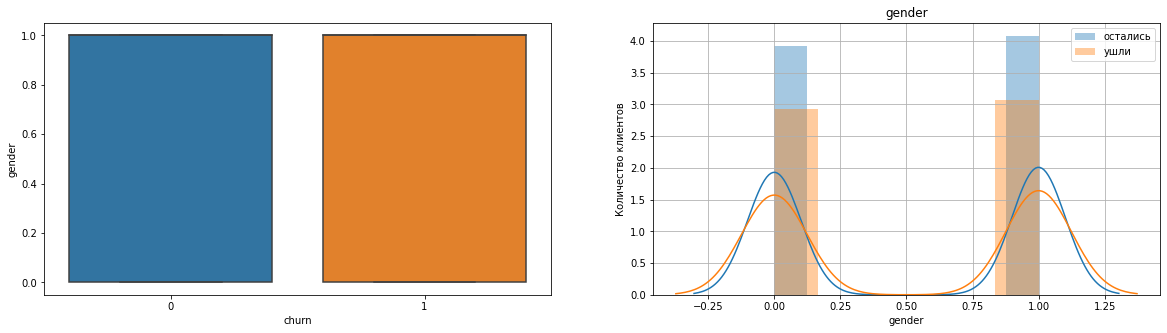

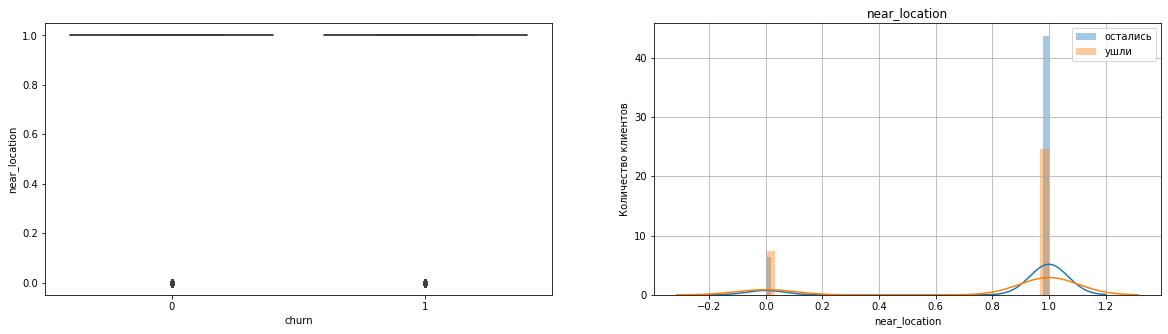

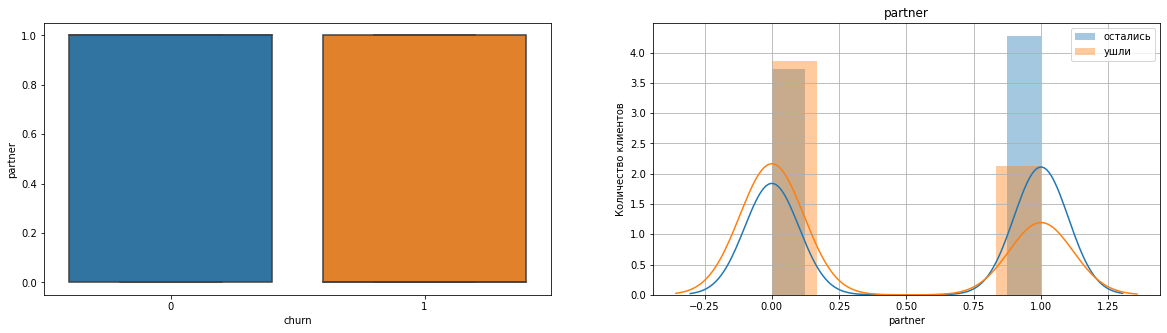

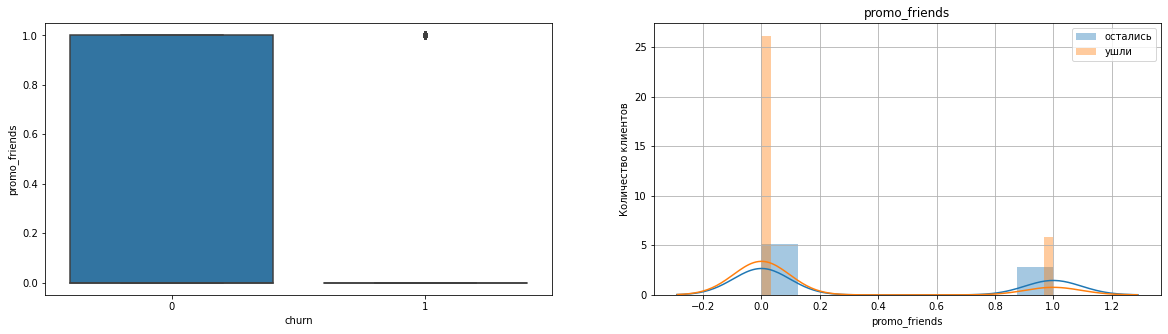

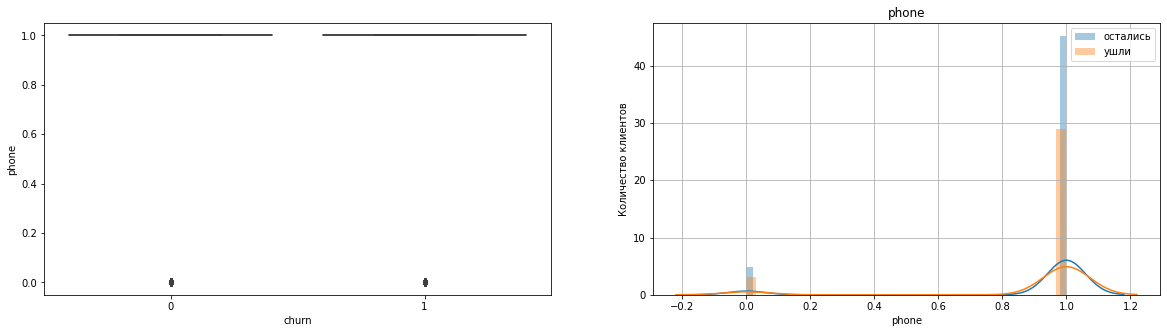

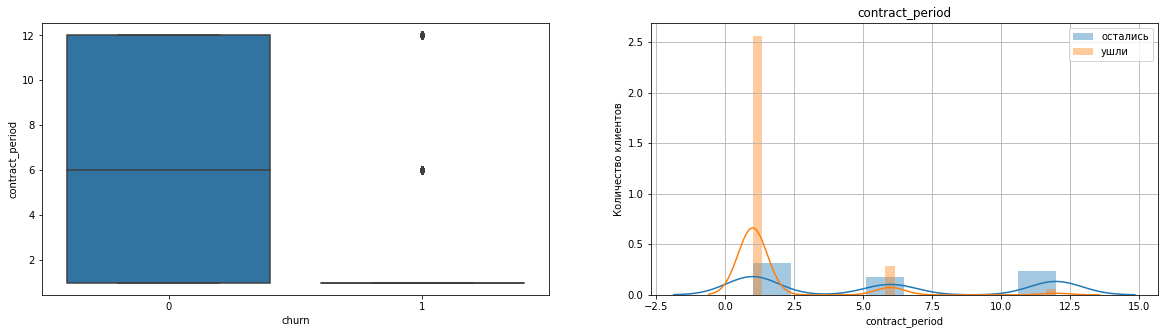

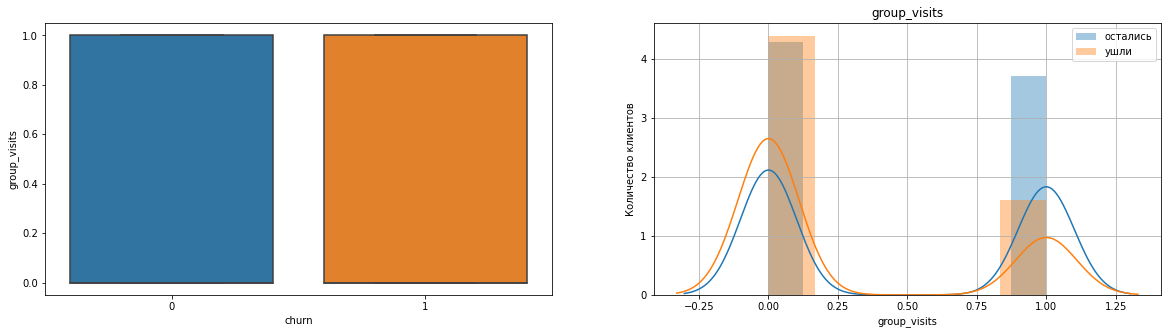

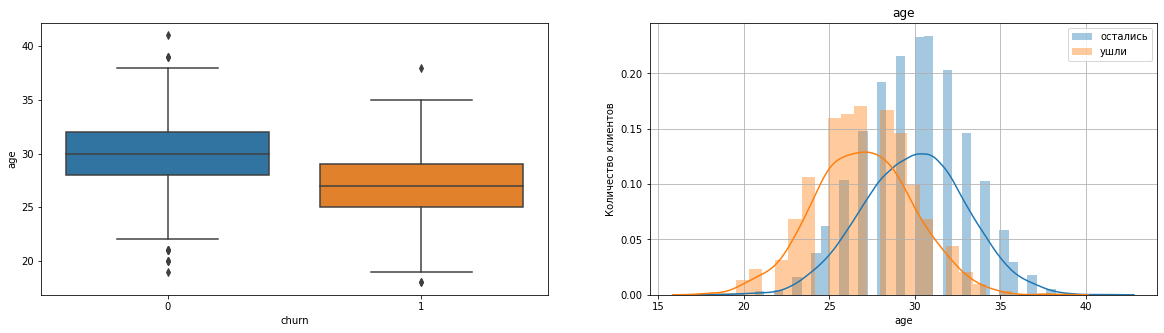

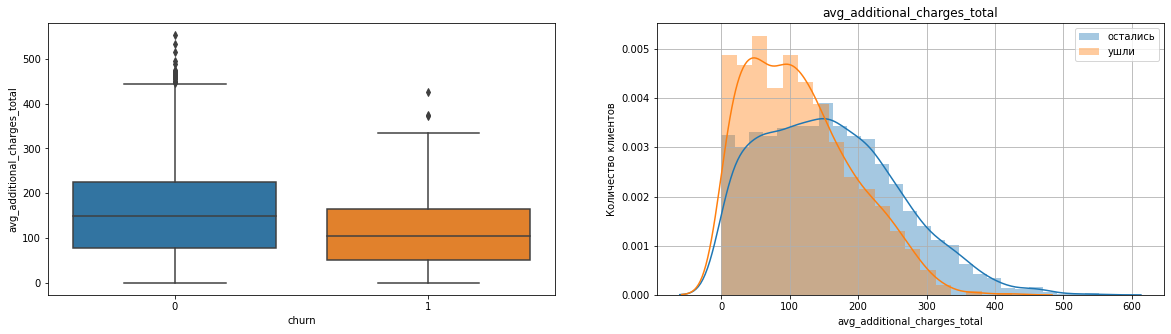

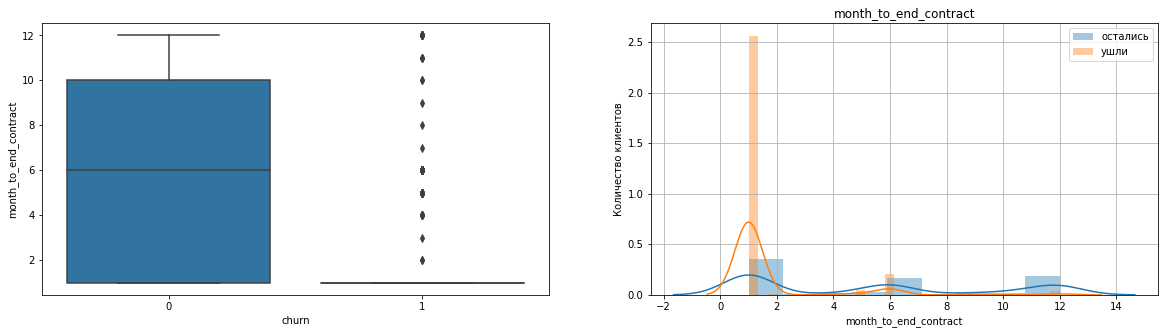

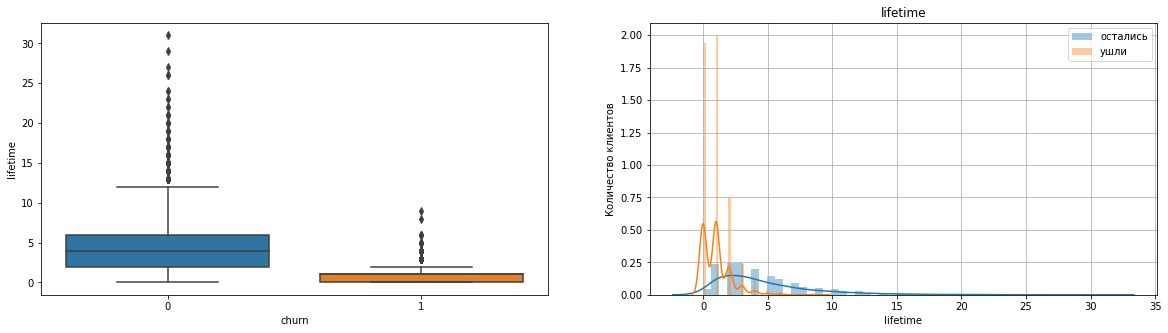

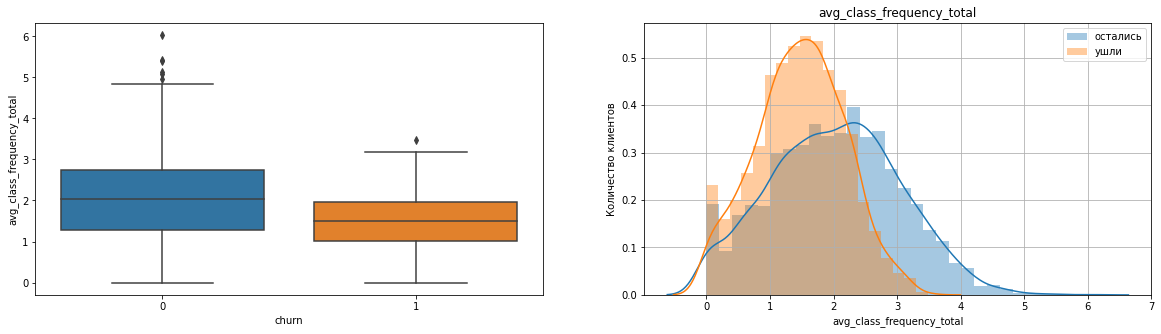

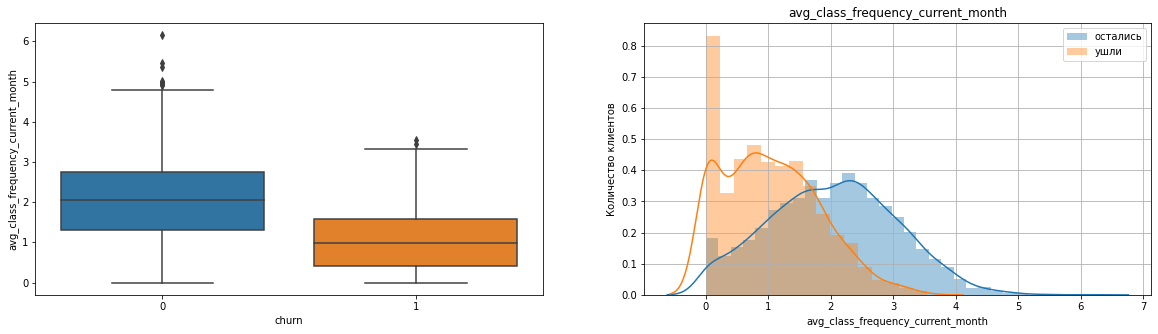

In [14]:
for i in data.drop('churn', axis=1).columns:
    plt.figure(figsize=(20, 5))
    ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(1, 2, 2)
    sns.boxplot(x='churn', y=i, data=data, ax=ax1)
    sns.distplot(data.loc[data['churn'] == 0, i], label='остались',ax=ax2)
    sns.distplot(data.loc[data['churn'] == 1, i], label='ушли',ax=ax2)

    plt.ylabel('Количество клиентов')
    plt.xlabel(f'{i}')
    plt.grid()
    plt.title(f'{i}')
    ax2.legend()
    plt.show();

У переменных довольно разные по величине стандартные отклонения. Это говорит о том, что их возможно нужно стандартизировать перед обучением. Но для логистической регрессии и дерева это не обязательно. Оставим их как есть.


**Лояльность проявляют:**
- сотрудники компаний партнеров;
- клиенты, проживающие в районе фитнес центра;
- клиенты с длительным сроком действия абонемента;
- клиенты посещающие групповые занятия;
- клиенты в возрасте от 28 лет

**Не проявляют лояльность и чаще попадают в отток**
- клиенты по акции "приведи друга"
- клиенты со сроком действия абонемента менее 6 месяцев, в особенности краткосрочных 1 месяц;
- клиенты в возрасте до 28 лет;
- те, кто не тратит либо тратит мало на доп. услуги;
- клиенты посещающие занятия реже двух раз в неделю

**Не влияют на отток:**
- Пол клиента;


В большинстве случаев распределения можно считать нормальными. За исключением, пожалуй, распределений по продаже доп. услуг, времени с момента первого обращения и среднего числа посещений за последний месяц.

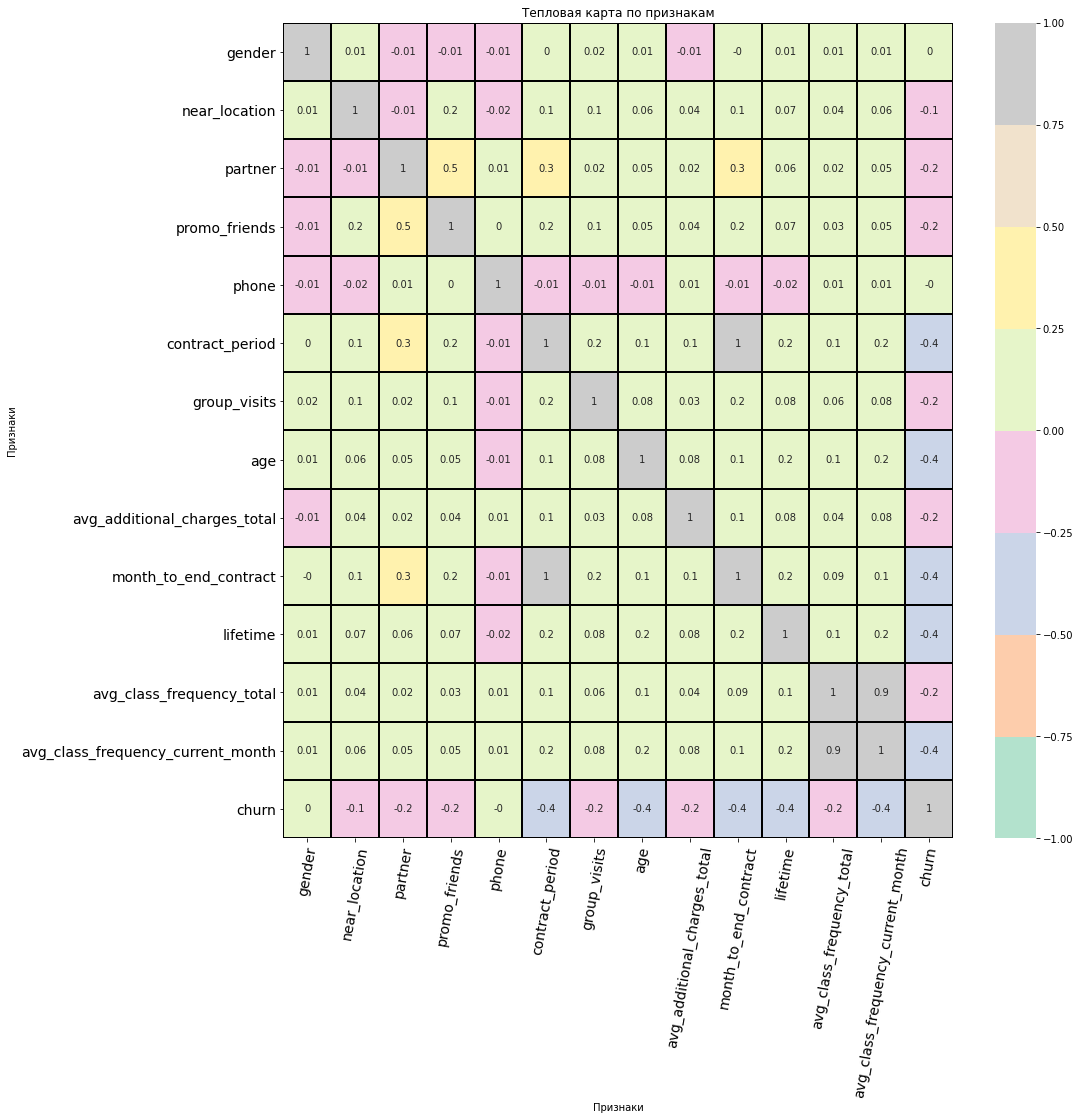

In [15]:
#построим и отрисуем матрицу корреляций
plt.figure(figsize=(15, 15))
sns.heatmap(data.corr().round(2), annot = True, fmt='.1g', vmin=-1, vmax=1, center= 0, cmap= 'Pastel2', linewidths=1, linecolor='black')
plt.title('Тепловая карта по признакам')
plt.xticks(fontsize=14, rotation=80)
plt.yticks(fontsize=14)
plt.ylabel('Признаки')
plt.xlabel('Признаки');

Признаки contract_period и month_to_end_contract  коррелируют (0.97), часто могут принимать одни значения, при покупке клиентом абонемента. <br>
Так же сильно коррелируют признаки avg_class_frequency_total и avg_class_frequency_current_month (0.9). <br>
Исключим для избежания ошибки обучения `contract_period` и `avg_class_frequency_current_month`.<br>
Незначительно коррелируют между собой признаки:
1. promo_friends и partner (0.5); 
2. churn и age (-0.4);
3. churn и avg_class_frequency_current_month (-0.4);
4. churn и lifetime (-0.4);
5. churn и contract_period (-0.4).<br>

Их можно оставить.

In [16]:
fitnes = data.drop(columns=['contract_period', 'avg_class_frequency_current_month'])

На данном шаге мы провели предобработку данных и исследовательский анализ EDA;<br>
Выявили для каких клиентов в большей степени характерен отток;<br>
<br>
Проверили на пропуски и дубликаты;<br>
Привели тип данных должным образом;<br>
<br>
Проверили корреляцию;<br>
Обнаружены признаки сильно коррелирующие друг с другом, исключили их.<br>

## Модель прогнозирования оттока клиентов

### Разбиение выборки на обучающую и валидационную

**Разделим данные на признаки и целевую переменную,  создадим две выборки, выведем для проверки**

In [17]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = fitnes.drop(columns='churn')
y = fitnes['churn']

#разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#проверим, правильно ли разбились обучающая и валидационная выборки
print('Изначальные признаки: X - {}, и целевых переменных y - {}'.format(len(X), len(y)))
print('Обучающие выбороки и процент от изначальной выборки: X_train - {}, {}% и y_train - {}, {}%'
       .format(len(X_train), round(len(X_train)*100 / len(X), 2), (len(y_train)), round(len(y_train)*100 / len(y), 2)))
print('Валидационные выбороки и процент от изначальной выборки: X_test - {}, {}% и y_test - {}, {}%'
       .format(len(X_test), round(len(X_test)*100 / len(X), 2), (len(y_test)), round(len(y_test)*100 / len(y), 2)))

Изначальные признаки: X - 4000, и целевых переменных y - 4000
Обучающие выбороки и процент от изначальной выборки: X_train - 3200, 80.0% и y_train - 3200, 80.0%
Валидационные выбороки и процент от изначальной выборки: X_test - 800, 20.0% и y_test - 800, 20.0%


In [18]:
# создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train) # обучаем scaler и одновременно трансформируем матрицу для обучающей выборки
X_test_st = scaler.transform(X_test) # применяем стандартизацию к матрице признаков для тестовой выборки


### Обучение моделей и сравнение метрик

**Посчитаем количество ушедших и оставшихся пользователей**

In [19]:
fitnes['churn'].value_counts()

0    2939
1    1061
Name: churn, dtype: int64

Распределение клиентов по группам 73.48%(оставшиеся), 26.52% (ушедшие)

In [20]:
# модели для будущего использования
models = [LogisticRegression, RandomForestClassifier]

Создадим функцию для обучения модели

In [21]:
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m(random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Accuracy: {:.2f} Precision: {:.2f} Recall: {:.2f}'.format(
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred)))
    
for i in models:
    print(i)
    make_prediction(i, X_train_st, y_train, X_test_st, y_test)

<class 'sklearn.linear_model._logistic.LogisticRegression'>
Accuracy: 0.90 Precision: 0.78 Recall: 0.81
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Accuracy: 0.90 Precision: 0.80 Recall: 0.77


Доля правильных ответов для логистической регрессии и случайного леса 0,9 - довольно высокий показатель.
Можем сделать вывод, что модель логистической регрессии лучше предсказывает отток клиентов (на 4%, чем модель случайного дерева)

## Кластеризация клиентов
### Построение матрицы расстояний

In [22]:
# создадим объект класса StandardScaler
scaler = StandardScaler()

# обучаем scaler и одновременно трансформируем матрицу признаков
X_st = scaler.fit_transform(X) 

Построим матрицу расстояний, а затем с её помощью и дендрограмму по признакам, наиболее сильно влияющим на отток клиентов

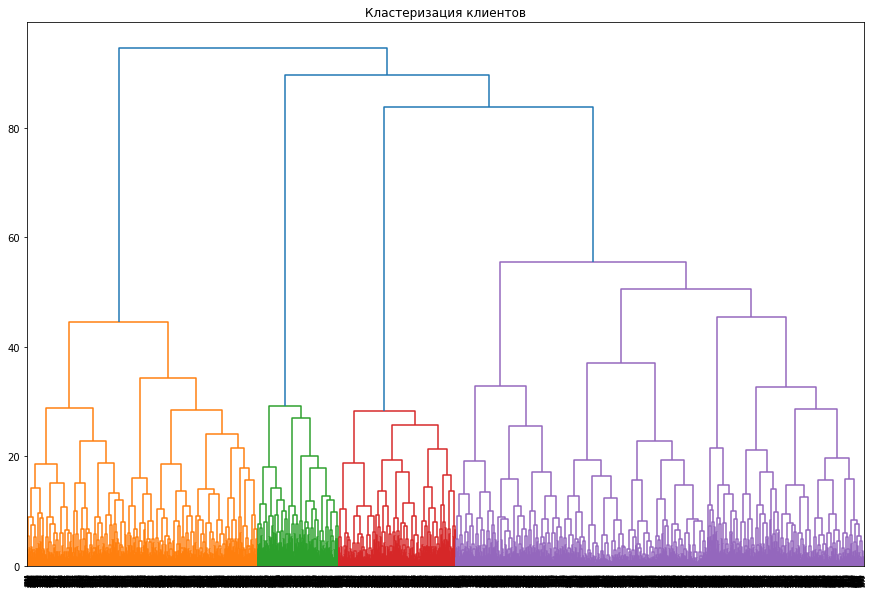

In [23]:
# Стандартизируем данные
linked = linkage(X_st, method = 'ward')

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Кластеризация клиентов')
plt.show() 

Предложенное оптимальное количество кластеров равно 4.

### Модель кластеризации K-Means
Зададим модель K-Means

In [24]:
# Хотя было предложено кол-во кластеров 4, по заданию необходимо принять число кластеров(n_clusters) 5.
km = KMeans(n_clusters=5, random_state=0) 
labels = km.fit_predict(X_st)

Посмотрим как распределились по кластерам клиенты.

In [25]:
fitnes['cluster'] = labels # добавляем колонку с номерами кластеров.
fitnes.sample(3)

,gender,near_location,partner,promo_friends,phone,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,churn,cluster
671,1,1,0,0,0,0,32,166.153122,1,0,1.034316,1,4
1787,1,1,1,1,1,1,31,190.514290,12,1,0.397329,0,0
1803,1,1,0,0,1,0,37,188.764657,1,15,0.269586,0,2


In [26]:
fitnes.groupby('cluster').mean().T # Сгруппируем клиентов по кластерам и выведем средние значения признаков

cluster,0,1,2,3,4
gender,0.498501,0.500898,0.521158,0.512090,0.523316
near_location,0.995005,0.000000,0.995546,1.000000,0.862694
partner,0.889111,0.488330,0.417595,0.196891,0.471503
promo_friends,1.000000,0.077199,0.011136,0.053541,0.305699
phone,1.000000,1.000000,1.000000,1.000000,0.000000
group_visits,0.519481,0.231598,0.546771,0.297064,0.427461
age,29.543457,28.685817,30.805122,27.818653,29.297927
avg_additional_charges_total,152.139417,137.277472,177.103564,124.625600,144.208179
month_to_end_contract,6.265734,2.804309,6.162584,1.898964,4.466321
lifetime,4.210789,2.978456,5.701559,2.058722,3.940415


При данной групперовке можно определить отток по кластерам:<br>
Меньше всего утекают клиентов из 2 кластера(1,67%). 0 и 4  незначительно(13 и 27%).<br>
Большой отток клиентов в 3 кластере - 50,6%.

In [27]:
fitnes.cluster.value_counts()

3    1158
0    1001
2     898
1     557
4     386
Name: cluster, dtype: int64

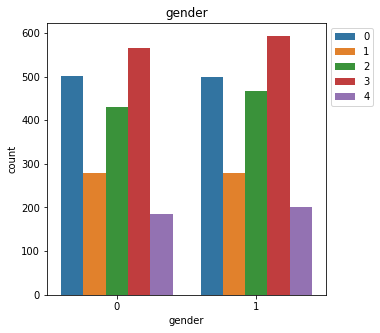

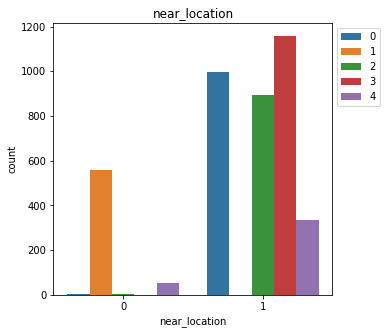

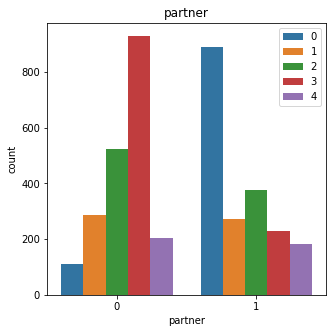

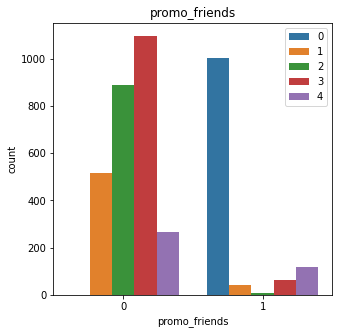

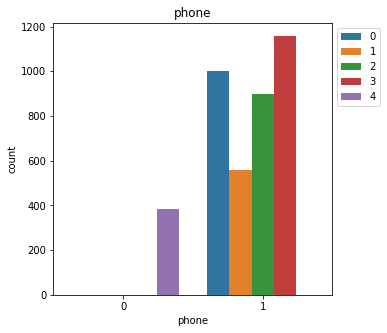

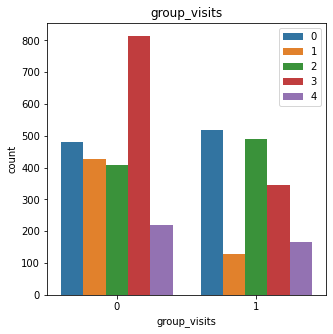

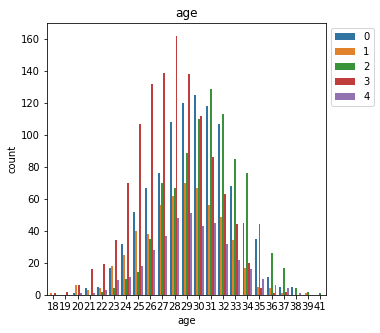

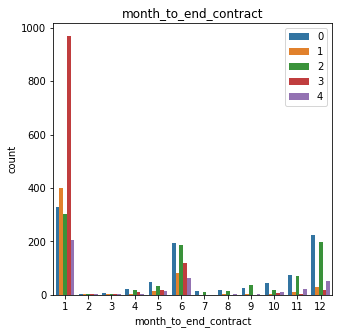

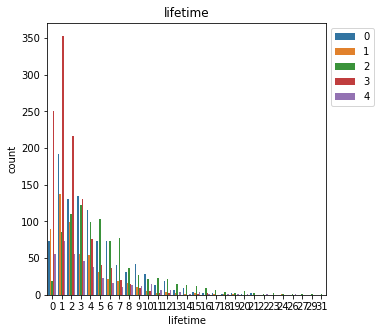

In [28]:
for column in ['gender', 'near_location', 'partner', 'promo_friends', \
               'phone', 'group_visits', 'age', 'month_to_end_contract',\
               'lifetime']:
 
    plt.figure(figsize=(5, 5))
    sns.countplot(x = fitnes[column], hue='cluster', data=fitnes)
    plt.title(column)
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()

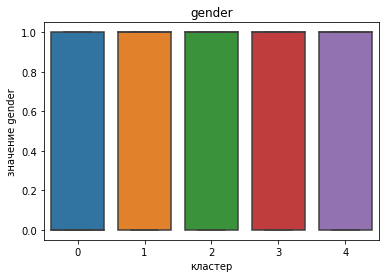

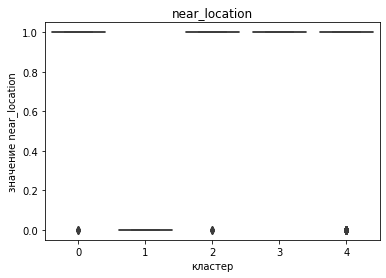

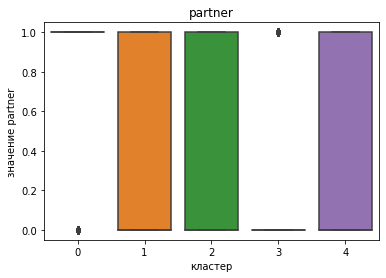

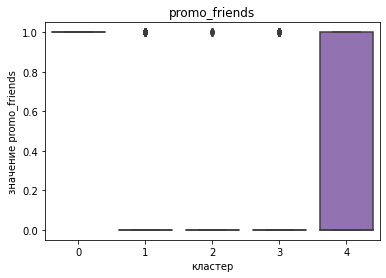

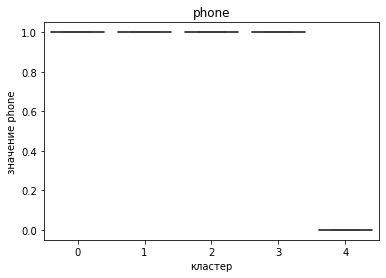

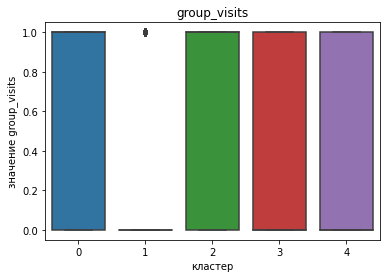

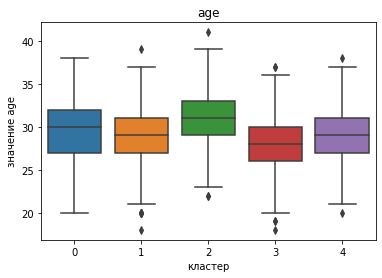

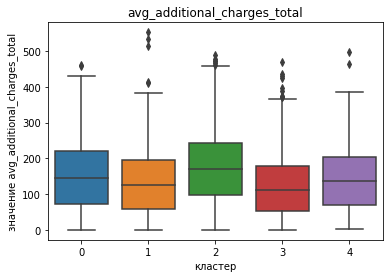

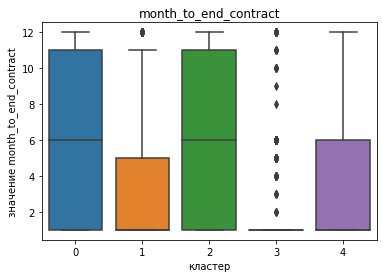

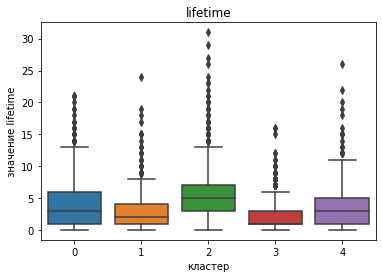

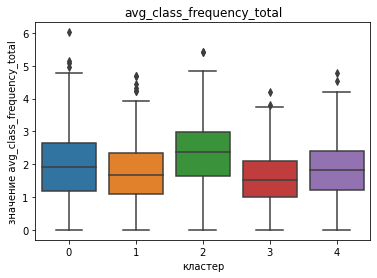

In [29]:
fig, ax = plt.subplots()
for column in fitnes.columns[0:-2]:
    plt.title(column)
    sns.boxplot(data=fitnes, x='cluster', y=column)
    plt.xlabel('кластер')
    plt.ylabel('значение '+column)
    plt.show()

**Разделили клиентов на 5 кластеров (с 0 по 4):**<br>
  
**"0"**: Проживают в районе клуба. 89% клиентов - партнеров. 52% посещает групповые занятия. Средний возраст 29 лет. До конца контракта 6 месяцев. Отток 13%;<br>
**Низкая доля оттока.**
**"1"** Проживают не в районе клуба.49% клиентов - партнеров. 23% посещает групповые заняти. Средний возраст 28 лет. До конца контракта 2 месяца. Отток 40%;<br>
**Высокая доля оттока.**
**"2"** Проживают в районе клуба.42% клиентов - партнеров. 55% посещают групповые занятия. Средний возраст 30 лет. До конца контракта 6 месяцев. Отток 2 %; <br>
Данные характеристики являются идеальными для Постоянного клиента.<br> 
**Очень низкая доля оттока.**
**"3"** Проживают не в районе клуба. 20% клиентов - партнеров. 30% посещают групповые занятия. Средний возраст 27 лет. 1 месяц до конца контракта. Отток 51%; <br>
**Очень высокая доля оттока.**
**"4"** Проживают не в районе клуба. 47% клиентов - партнеров. 43% посещают групповые занятия. Средний возраст 29 лет. 4 месяца до конца контракта. Отток 27%.<br>
**Низкая доля оттока.**  

## Выводы и рекомендации по проекту

Проанализировали данные клиентов фитнес-центра. 
По существующим данным построили две модели прогноза оттока клиентов.
Проведена кластеризация клиентов. 
Построенная дендрограмма показала 4 явных кластера, согласно заданию, выборку разделили на 5 кластеров. 
Построили распределение признаков по кластерам, на основании которых построили портрет постоянного клиента.

Идеальный клиент: Проживает в районе клуба. Сотрудник компании-партнёра клуба. Посещают групповые занятия. Средний возраст 30 лет. Контракт на 6 или 12 месяцев.

Рекомендации:

Проводить маркетинговые активности, направленные на целевую аудиторию:
- Увеличить расходы на рекламу в близлежащих районах (клиенты из других районов не станут постоянными);
- Реклама нацедена на клиентуру в возрасте 30+;

Работа с действующими клиентами:
- Активнее предлагать и мотивировать к групповым занятиям.

Продажи:

- Мотивировать отдел продаж предлагать и продавать клиентам долгосрочные абонементы;

Партнеры:
- Наращивать партнерскую программу в организациях, т.к. клиенты из компаний партнеров менее склонны к оттоку;